## Import Modules

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import cv2
import random
import tensorflow as tf
from tensorflow import keras
from joblib import dump, load
from tkinter import *
from tkinter import filedialog

### Show a few Examples of the Dataset

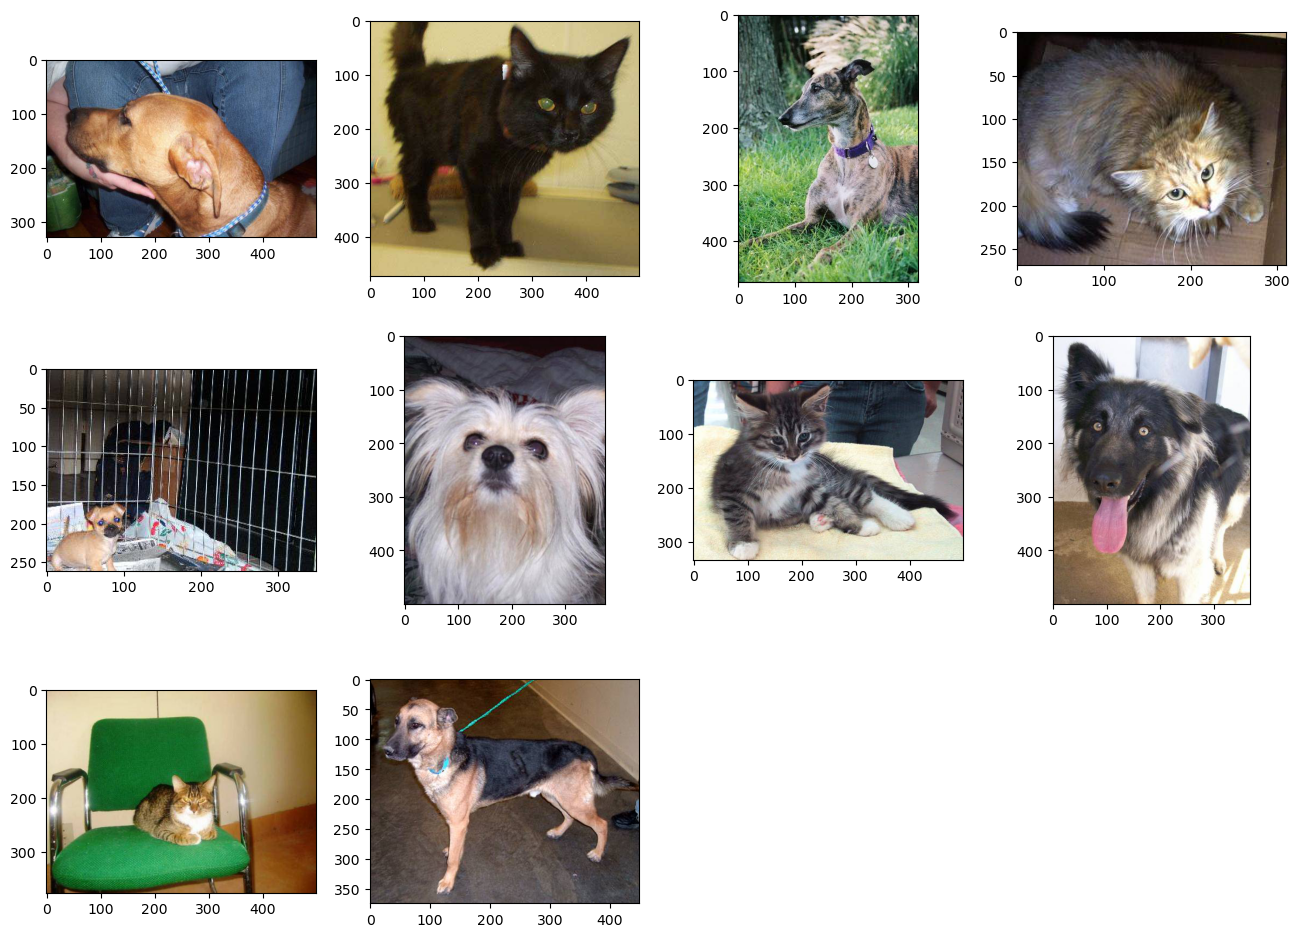

In [2]:
class_names = ["cat", "dog"]
main_dir = "dataset"
train_dir = "train"
path = os.path.join(main_dir, train_dir)
images = os.listdir(path)
plt.figure(figsize=(16, 16))

for i in range(10):
   img = random.choice([x for x in images])
   fig = plt.subplot(4, 4, i + 1)
   img = mpimg.imread(os.path.join(path, img))
   fig.imshow(img)

### Pre-process the Training Data

In [3]:
X_train = []
y_train = []
convert = lambda category : int(category == "dog")

for p in os.listdir(path):
    category = p.split(".")[0]
    category = convert(category)
    img_array = cv2.imread(os.path.join(path, p))
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    X_train.append(new_img_array)
    y_train.append(category)
    
X_train = np.array(X_train).reshape(-1, 80, 80, 3)
y_train = np.array(y_train)

### Pre-process the Test Data

In [12]:
test_dir = "test"
path = os.path.join(main_dir, test_dir)

X_test = []
y_test = []

for p in os.listdir(path):
    y_test.append(p.split(".")[0])
    img_array = cv2.imread(os.path.join(path, p))
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    X_test.append(new_img_array)
    
X_test = np.array(X_test).reshape(-1, 80, 80, 3)
y_test = np.array(y_test)

### Normalize Data

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Build CNN

In [6]:
model = keras.models.Sequential()

# Adds a densly-connected layer to the model
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(80, 80, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

# Add another layer
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

# And another layer
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

# Guess what..? Add another layer
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

# Flatten, then feed the data to the Dense layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 39, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

### Complie the model

In [8]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Fit Model with Training Data, Validating Against the Test Data

In [9]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
625/625 [==============================] - 62s 98ms/step - loss: 0.6201 - accuracy: 0.6628 - val_loss: 0.9325 - val_accuracy: 0.3542
Epoch 2/20
625/625 [==============================] - 59s 94ms/step - loss: 0.5192 - accuracy: 0.7445 - val_loss: 0.7773 - val_accuracy: 0.5672
Epoch 3/20
625/625 [==============================] - 59s 94ms/step - loss: 0.4341 - accuracy: 0.7977 - val_loss: 0.4970 - val_accuracy: 0.7612
Epoch 4/20
625/625 [==============================] - 59s 95ms/step - loss: 0.3661 - accuracy: 0.8342 - val_loss: 0.8773 - val_accuracy: 0.5890
Epoch 5/20
625/625 [==============================] - 61s 97ms/step - loss: 0.3039 - accuracy: 0.8680 - val_loss: 0.7805 - val_accuracy: 0.6444
Epoch 6/20
625/625 [==============================] - 59s 95ms/step - loss: 0.2563 - accuracy: 0.8911 - val_loss: 0.4749 - val_accuracy: 0.7852
Epoch 7/20
625/625 [==============================] - 59s 94ms/step - loss: 0.2117 - accuracy: 0.9129 - val_loss: 0.4664 - val_accuracy:

### Data Model Persistence

In [15]:
# dump(model, "model.joblib")
model.save("dog_cat_classifier.model")

INFO:tensorflow:Assets written to: dog_cat_classifier.model\assets


INFO:tensorflow:Assets written to: dog_cat_classifier.model\assets


### Reload Data Model

In [41]:
# model = load("model.joblib")
model = keras.models.load_model("dog_cat_classifier.model")

### Making predictions With Test Data

In [13]:
predictions = model.predict(X_test)
predicted_val = [int(round(p[0])) for p in predictions]

391/391 [==============================] - 8s 21ms/step


In [14]:
pd.DataFrame({"id": y_test, "Cat=0, Dog=1": predicted_val})

,id,"Cat=0, Dog=1"
0,1,1
1,10,0
2,100,0
3,1000,1
4,10000,1
...,...,...
12495,9995,0
12496,9996,1
12497,9997,1
12498,9998,0


### Make Visualization of Accuracy Results

In [16]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

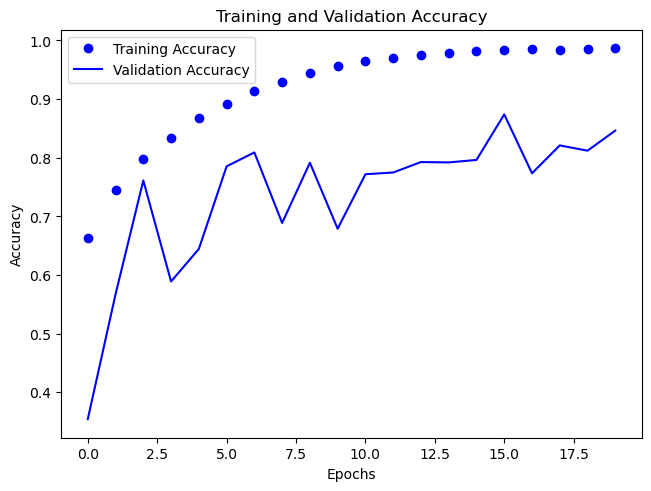

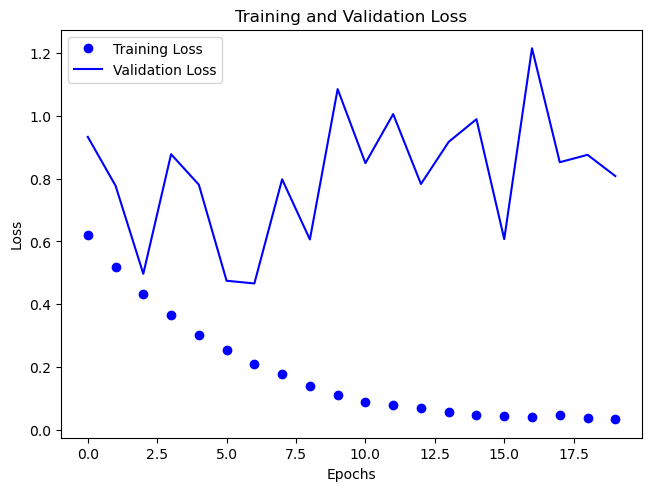

In [17]:
fig_1, ax_1 = plt.subplots(layout="constrained")
ax_1.plot(epochs, acc, "bo", label="Training Accuracy")
ax_1.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax_1.set_title("Training and Validation Accuracy")
ax_1.set_xlabel("Epochs")
ax_1.set_ylabel("Accuracy")
ax_1.legend()

fig_2, ax_2 = plt.subplots(layout="constrained")
ax_2.plot(epochs, loss, "bo", label="Training Loss")
ax_2.plot(epochs, val_loss, "b", label="Validation Loss")
ax_2.set_title("Training and Validation Loss")
ax_2.set_xlabel("Epochs")
ax_2.set_ylabel("Loss")
ax_2.legend()

## Notebook Interactivity

### Have User Select a Cat or Dog Image

In [59]:
filepath = Tk().filename = filedialog.askopenfilename(title="Select A File", filetypes=(("Jpg files", "*.jpg"), ("All Files", "*.*")))
Tk().mainloop()

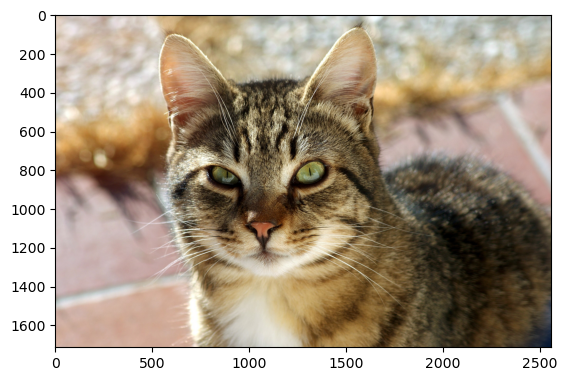

In [60]:
img_array = cv2.imread(filepath)
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

plt.imshow(img_array, cmap=plt.cm.binary)

### Re-scale Selected Image

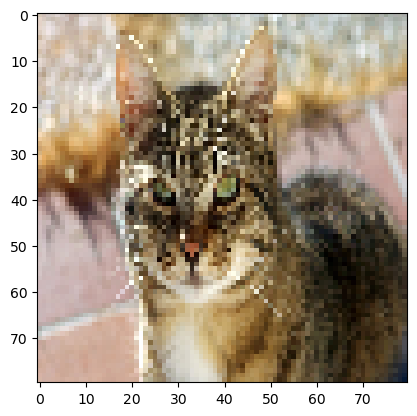

In [61]:
resized_img_array = cv2.resize(img_array, dsize=(80, 80))
plt.imshow(resized_img_array, cmap=plt.cm.binary)

### Make Prediction

In [62]:
test = []
test = np.array([resized_img_array]).reshape(-1, 80, 80, 3)
test = test / 255
prediction = model.predict(test)

1/1 [==============================] - 0s 19ms/step


In [63]:
print(prediction)
# index = np.argmax(prediction)
# print(index)

[[0.8979852]]
